In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

In [2]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Function used to the index of the emojis in a set of tokens

In [3]:
df = pd.read_pickle("emoji_vectors_data.pkl")
df.head()

,tweet_id,embedding,emoji_id
0,748304287315468288,"[-0.47280642, 0.11537896, 0.27408963, 0.137825...",871
1,593564841647992832,"[-0.20254304, -0.1832999, -0.08655356, 0.12977...",871
2,1189693284391833600,"[-0.29617956, -0.16728494, 0.20603363, 0.20679...",871
3,660244596664893440,"[-0.1807276, -0.016389936, 0.11193222, 0.14420...",871
4,538844422410993664,"[0.36076596, -0.046867955, 0.16463731, 0.15527...",871


In [4]:
tweets = pd.read_csv("tweets_data.csv").dropna(subset=["tweet_id"])
tweets.head()

,author_id,created_at,geo,tweet_id,like_count,quote_count,reply_count,retweet_count,text
0,431948312,2017-01-30 23:55:49+00:00,,826217383039729664,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny
1,418718492,2017-05-30 23:56:15+00:00,,869704038048202752,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...
2,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},792878143887605760,1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...
3,1249825087525728257,2020-10-30 23:59:39+00:00,,1322327339200630784,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣
4,205097885,2018-03-30 23:54:29+00:00,,979869505622069248,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...


In [6]:
df.emoji_id.nunique()

47

There are 47 emojis to choose from

The emoji frequencies are vary greatly. Some are in the six figures while 

In [7]:
emoji_freq = df.emoji_id.value_counts()
emoji_freq.head(10)

88      402897
247     163274
280     114094
390     103253
933      28369
1658     27541
1422     21795
491      15105
6239     15096
722      12182
Name: emoji_id, dtype: int64

Convert ids to emojis

In [8]:
ef_index = emoji_freq.index
ef_index = ef_index.map(tokenizer.convert_ids_to_tokens)
emoji_freq.set_axis(ef_index.map(emoji.EMOJI_UNICODE_ENGLISH)).head(15)

😂     402897
😭     163274
❤️    114094
😍     103253
🙏      28369
✨      27541
🤣      21795
😩      15105
🥺      15096
😘      12182
💕      12180
💀       8728
💖       7127
🔥       6668
🏽       6661
Name: emoji_id, dtype: int64

For our first example, let's start with the prayer hands emoji

In [9]:
prayer_hands_id = 933

prayer_hands_df = df.query("emoji_id == {}".format(prayer_hands_id)).drop("emoji_id", axis = 1)
prayer_hands_df

,tweet_id,embedding
0,649010168466796544,"[0.17880017, 0.05944991, 0.029669717, 0.362047..."
1,649010168466796544,"[0.31431267, 0.11376719, -0.017697126, 0.36743..."
2,649010168466796544,"[0.27834195, 0.033847056, 0.08875726, 0.325185..."
3,1233542243899731968,"[-0.5153002, -0.07138766, 0.07983874, -0.02516..."
4,1454598713612046336,"[-0.49861014, 0.15797623, 0.02909191, 0.323536..."
...,...,...
28364,693583914112159744,"[-0.17743944, 0.2504055, 0.19830742, 0.2940904..."
28365,550078795202699264,"[0.22381634, 0.17009586, -0.054807916, 0.36430..."
28366,550078795202699264,"[0.14281055, 0.17582378, -0.021657616, 0.57792..."
28367,550078795202699264,"[0.38438046, 0.34984455, -0.12370965, 0.483517..."


There are 28369 instances of the prayer hands emoji being used over the course of 8 years.

There are 21019 unique tweets that use the prayer hands emoji.

In [11]:
prayer_hands_df.tweet_id.nunique()

21019

A tiny sample of the tweets in this dataframe frequently use the prayer hands emojis

In [12]:
prayer_hands_df.tweet_id.value_counts()

615670335338233856     43
1046187630948429824    35
1079527433794137984    29
1012848168336179200    16
494633200657121280     15
                       ..
1277753287404593152     1
1012848084865486848     1
1454598945892618240     1
1322326937109409792     1
561312901492129792      1
Name: tweet_id, Length: 21019, dtype: int64

Let's see there are any temporal trends in the prayer hands emoji in this eight year time-span.

Connect the timestamp data from tweets by joining `tweets` with `prayer_hands_df`

In [17]:
prayer_hands_df = pd.merge(prayer_hands_df, tweets, on = "tweet_id")

In [18]:
prayer_hands_df.shape

(28369, 10)

In [20]:
tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()
tweet_rate

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_81868/3823679294.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()


created_at
2014-01-30 23:57:31+00:00   NaN
2014-01-30 23:57:31+00:00   NaN
2014-01-30 23:57:31+00:00   NaN
2014-01-30 23:57:31+00:00   NaN
2014-01-30 23:57:32+00:00   NaN
                             ..
2021-12-30 23:59:57+00:00   NaN
2021-12-30 23:59:58+00:00   NaN
2021-12-30 23:59:58+00:00   NaN
2021-12-30 23:59:58+00:00   NaN
2021-12-30 23:59:59+00:00   NaN
Length: 28369, dtype: float64

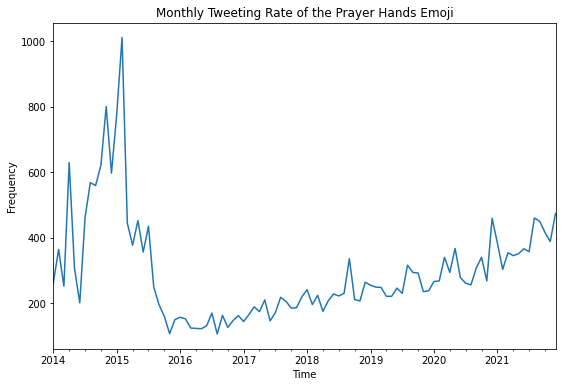

In [28]:
tweet_rate.resample("M").size().plot(figsize = (9,6))
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

There was a big spike in 2015, followed by a crash in 2016, and since then it's been on a steady uprise.

Now let's move onto the clustering. But first we need to prepare the embeddings data.

In [31]:
prayer_embeddings = prayer_hands_df.embedding
prayer_embeddings.head()

0    [0.17880017, 0.05944991, 0.029669717, 0.362047...
1    [0.31431267, 0.11376719, -0.017697126, 0.36743...
2    [0.27834195, 0.033847056, 0.08875726, 0.325185...
3    [-0.5153002, -0.07138766, 0.07983874, -0.02516...
4    [-0.49861014, 0.15797623, 0.02909191, 0.323536...
Name: embedding, dtype: object

Transform the data so that it each value in the embedding array is organized under a single column

In [33]:
prayer_embeddings = prayer_embeddings.apply(pd.Series)
prayer_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.178800,0.059450,0.029670,0.362048,-0.092572,-0.090097,0.056386,0.252641,0.187725,0.016247,...,0.187791,-0.361425,0.131782,0.127891,-0.284731,0.031908,0.065007,0.019091,-0.536011,0.011186
1,0.314313,0.113767,-0.017697,0.367432,-0.031179,-0.103953,0.092101,0.188067,0.316456,0.267391,...,0.087665,-0.313290,0.101829,0.229156,-0.241067,-0.055159,0.007168,-0.049920,-0.391997,0.050951
2,0.278342,0.033847,0.088757,0.325186,-0.001255,-0.589844,0.177111,0.269309,0.355679,0.166622,...,0.079534,-0.504104,-0.077147,0.052155,0.114016,0.118626,-0.132879,0.110086,-0.582188,-0.071241
3,-0.515300,-0.071388,0.079839,-0.025169,0.309406,-0.511755,0.300661,0.077642,0.342054,0.196609,...,0.272639,0.171139,-0.101986,0.448649,-0.298791,0.264860,-0.110508,-0.053058,-0.447471,-0.265488
4,-0.498610,0.157976,0.029092,0.323537,-0.170732,-0.101166,0.393581,0.203327,0.067146,-0.185658,...,0.379231,-0.281076,0.412709,-0.152941,0.028670,-0.278824,-0.020245,0.361500,-0.822515,0.226682


We begin with a simple KMeans with k = 3

In [37]:
%%time
km = KMeans(n_clusters=3, random_state=10)
km.fit(prayer_embeddings)

CPU times: user 32 s, sys: 7.44 s, total: 39.5 s
Wall time: 4.34 s


KMeans(n_clusters=3, random_state=10)

In [38]:
prayer_labels_k3 = km.labels_

Evaluate model using silhouette score

In [39]:
silhouette_score(prayer_embeddings, prayer_labels_k3)

0.12503745

0.125 is not a bad score but let's do bit of parameter tuning in order to find the best k value

In [46]:
sil_scores = []

k_range = range(2, 21)

for k in tqdm(k_range, total=19):
    km = KMeans(n_clusters=k, random_state=10)
    km.fit(prayer_embeddings)
    labels = km.labels_
    s_score = silhouette_score(prayer_embeddings, labels)
    sil_scores.append(s_score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [08:45<00:00, 27.64s/it]


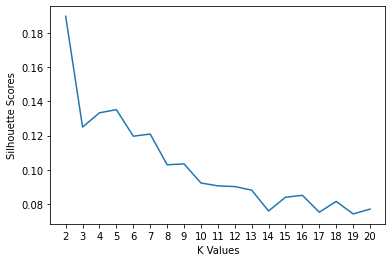

In [48]:
plt.plot(k_range, sil_scores)
plt.xlabel("K Values")
plt.ylabel("Silhouette Scores")
plt.xticks(ticks = k_range);

2 is obviously the best k value (this is typically the case), but 5 is worth examining as becuase it's a local maximum. 

In [50]:
km2 = KMeans(n_clusters=2, random_state=10)
km2.fit(prayer_embeddings)
labels_2 = km2.labels_


km5 = KMeans(n_clusters=5, random_state=10)
km5.fit(prayer_embeddings)
labels_5 = km5.labels_

Visualize the embeddings in a 2D scatter plot, color-encoding the dots with labels.

In [49]:
tsne = TSNE(random_state=10)
prayer_tsne = tsne.fit_transform(prayer_embeddings)

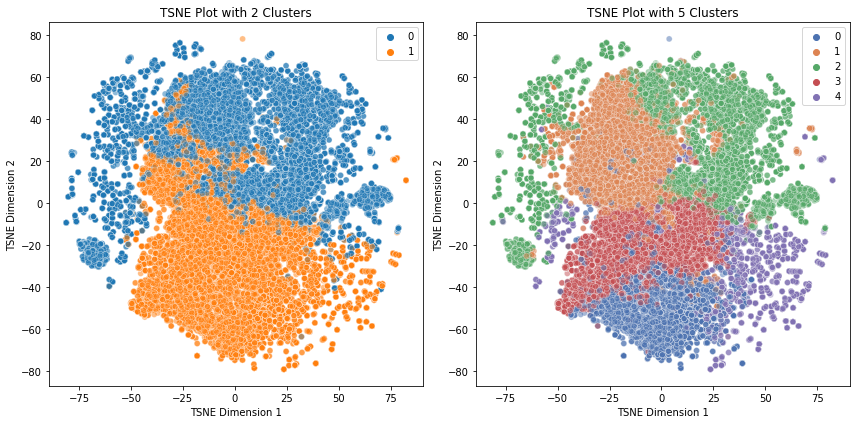

In [66]:
tsne1 = prayer_tsne[:, 0]
tsne2 = prayer_tsne[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot on the left subplot

sb.scatterplot(x = tsne1, y = tsne2, hue=labels_2,ax = axs[0], alpha = .5)
axs[0].set_title('TSNE Plot with 2 Clusters')

# Plot the second scatter plot on the right subplot
sb.scatterplot(x = tsne1, y = tsne2, hue=labels_5,ax = axs[1], alpha = .5, palette = "deep")
axs[1].set_title('TSNE Plot with 5 Clusters')


axs[0].set_xlabel('TSNE Dimension 1')
axs[0].set_ylabel('TSNE Dimension 2')
axs[1].set_xlabel('TSNE Dimension 1')
axs[1].set_ylabel('TSNE Dimension 2')
fig.tight_layout()

# Show the plot
plt.show()


This is a promising result, we can observe distinguishable clusters of the prayer_hands emoji's meaning

What are the distributions of the labels for each model

In [70]:
print(pd.value_counts(labels_2), "\n")
print(pd.value_counts(labels_2, normalize=True))

0    14509
1    13860
dtype: int64 

0    0.511439
1    0.488561
dtype: float64


In [71]:
print(pd.value_counts(labels_5), "\n")
print(pd.value_counts(labels_5, normalize=True))

2    9479
1    6377
3    5409
0    3864
4    3240
dtype: int64 

2    0.334132
1    0.224788
3    0.190666
0    0.136205
4    0.114209
dtype: float64


Now let's dive into what those clusters mean.

In [77]:
prayer_hands_df["labels2"] = labels_2
prayer_hands_df["labels5"] = labels_5

Remember that `prayer_hands_df` has duplicate tweets because each row represent one use of the prayer hands emoji and in some tweets there are multitple instances of that emoji.

Here I group by the `tweet_id` and apply the `value_counts` function to the cluster labels

In [106]:
labels2_df = prayer_hands_df.groupby("tweet_id").labels2.value_counts().unstack().fillna(0)
labels2_df.head()

labels2,0,1
tweet_id,,
429040710663168000,0.0,1.0
429040711967993856,1.0,0.0
429040712110186496,0.0,1.0
429040713247256576,1.0,0.0
429040714149007360,1.0,0.0


`labels2_df` shows the frequency of each cluster appearing in a tweet.

Repeat this process for 5 labels

In [107]:
labels5_df = prayer_hands_df.groupby("tweet_id").labels5.value_counts().unstack().fillna(0)
labels5_df.head()

labels5,0,1,2,3,4
tweet_id,,,,,
429040710663168000,0.0,0.0,0.0,1.0,0.0
429040711967993856,0.0,0.0,0.0,1.0,0.0
429040712110186496,0.0,0.0,0.0,1.0,0.0
429040713247256576,0.0,0.0,1.0,0.0,0.0
429040714149007360,0.0,1.0,0.0,0.0,0.0


Now I need to pull text belonging to a single cluster

In [111]:
cluster0_ids = labels2_df[labels2_df.iloc[:, 0] == 1].index

In [113]:
cluster0_text = tweets[tweets.tweet_id.isin(cluster0_ids)].text

Put it into a wordcloud

In [117]:
#normalize the text

cluster0_text = cluster0_text.apply(tokenizer.normalizeTweet)

In [120]:
wc = WordCloud(stopwords=STOPWORDS)

In [ ]:
wc.generate()

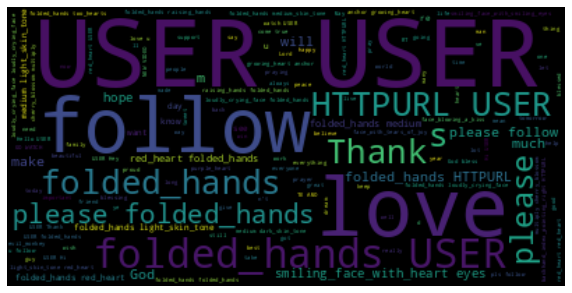

In [119]:
cluster0_wc = WordCloud(stopwords=STOPWORDS).generate(" ".join(cluster0_text))

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(cluster0_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
class ClusterHub:
    
    def __init__(self, emoji_id):
        